In [1]:
'''
Attribution: https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing#scrollTo=Z1mJVbKorh5y
'''

import random
from collections import defaultdict, namedtuple
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.nn import GraphConv
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.data import Data, DataLoader
from captum.attr import IntegratedGradients, Saliency, LayerConductance, NeuronConductance

from models import BaselineModel, GCNPair, GCNEntPair, EntNet
from dataloaders import DDIGraphDataset, DDIData
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/hopan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/hopan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True

In [2]:
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    r"""Converts a :class:`torch_geometric.data.Data` instance to a
    :obj:`networkx.Graph` if :attr:`to_undirected` is set to :obj:`True`, or
    a directed :obj:`networkx.DiGraph` otherwise.

    Args:
        data (torch_geometric.data.Data): The data object.
        node_attrs (iterable of str, optional): The node attributes to be
            copied. (default: :obj:`None`)
        edge_attrs (iterable of str, optional): The edge attributes to be
            copied. (default: :obj:`None`)
        to_undirected (bool, optional): If set to :obj:`True`, will return a
            a :obj:`networkx.Graph` instead of a :obj:`networkx.DiGraph`. The
            undirected graph will correspond to the upper triangle of the
            corresponding adjacency matrix. (default: :obj:`False`)
        remove_self_loops (bool, optional): If set to :obj:`True`, will not
            include self loops in the resulting graph. (default: :obj:`False`)
    """

    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()

    G.add_nodes_from(range(data.num_nodes))

    values = {}
    for key, item in data:
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]

    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue

        G.add_edge(u, v)
        for key in edge_attrs if edge_attrs is not None else []:
            G[u][v][key] = values[key][i]

    for key in node_attrs if node_attrs is not None else []:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})

    return G

In [3]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False, ax=None):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure', ax=ax)
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', ax=ax)

In [4]:
def load_model(fname='./saved_models/gcnpairgraph_gconv_1024h.pth'):
    n = 1024
    model = GCNPair(32, n, 299, nlayers=2, dec='mlp', base_gcn='GraphConv')
    checkpoint = torch.load(fname, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [5]:
def to_molecule(data):
    ATOM_TYPES =  {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'Si':  5, 'P':  6, 'S':  7, 'Cl':  8, 'Br':  9, 'I': 10}
    ATOM_MAP = {idx: atom for atom, idx in ATOM_TYPES.items()}
    
    g = to_networkx(data, node_attrs=['x'], to_undirected=True)
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x']]
        del data['x']
    return g

In [6]:
def pair_to_single(pair):
    '''
    pair: 
    '''
    p1 = Data(x=pair.x1, edge_index=pair.edge_index1)
    p2 = Data(x=pair.x2, edge_index=pair.edge_index2)
    return p1, p2

### Doing Forward pass for Integrated Gradients/Saliency

In [7]:
data_fn = './data/ddi_pairs.txt'
struc_fn = './data/3d_struc.csv'
#train_data, test_data = get_data(data_fn, struc_fn)
dataset = DDIGraphDataset(data_fn, struc_fn)
model = load_model()
model

2126it [00:02, 745.34it/s]


post filter length df: 465765


GCNPair(
  (gcn): BasicGCN2(
    (atom_encoder): Embedding(11, 32)
    (gcn_layers): ModuleList(
      (0): GraphConv(32, 1024)
      (1): GraphConv(1024, 1024)
    )
    (fc): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=299, bias=True)
  )
)

In [8]:
def gen_fwd_batch(b):
    '''
    Given a batch of data, creates the model forward pass function to pass into
    IntegratedGradients/Saliency explainer
    Need this function to create the closure that encapsulates the rest of the inputs
    needed in the forward pass (discrete atom label, edge index of the pair of graphs)
    b: Pytorch geometric minibatch
    '''
    x1, e1 = b.x1, b.edge_index1
    x2, e2 = b.x2, b.edge_index2
    b1 = torch.zeros(x1.shape).long()
    b2 = torch.zeros(x2.shape).long()
    def func(em1, em2):
        return model.forward_all(x1, e1, b1, x2, e2, b2, em1, em2)
    
    return func

def explain_pair(model, pair_graph, target, method='ig'):
    x1, e1 = pair_graph.x1, pair_graph.edge_index1
    x2, e2 = pair_graph.x2, pair_graph.edge_index2
    
    model_forward = gen_fwd_batch(pair_graph) 
    # edge masks
    em1 = torch.ones(e1.shape[1]).requires_grad_(True)
    em2 = torch.ones(e2.shape[1]).requires_grad_(True)
    if method == 'ig':
        attr = IntegratedGradients(model_forward)
        mask1, mask2 = attr.attribute(inputs=(em1, em2), target=target, internal_batch_size=e1.shape[1])
    elif method == 'saliency':
        attr = Saliency(model_forward)
        mask1, mask2 = attr.attribute(inputs=(em1, em2), target=target)
        
    if mask1.max() > 0:
        mask1 = mask1 / mask1.max()
    if mask2.max() > 0:
        mask2 = mask2 / mask2.max()
        
    mask1 = np.abs(mask1.cpu().detach().numpy())
    mask2 = np.abs(mask2.cpu().detach().numpy())
    return mask1, mask2

def aggregate_edge_directions(edge_mask, edge_index):
    '''
    edge_mask: tensor of shape n
    edge_index: long tensor of shape 2 x n
    Returns: dictionary mapping tuples (src, target) -> float (magnitude of gradient)
    '''
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def plot_explain(model, pair_graph, target, axs, method="ig"):
    '''
    model: pytorch module
    pair_graph: Pair graph batch object (see dataloaders.py:DDIGraphDataset)
    target: int, label of pair of Drugs interaction
    axs: list of matplotlib axs
    method: string ('ig' or 'saliency')
    
    Plots the explainability via edge attributions
    '''
    g1, g2 = pair_to_single(pair_graph)
    em1, em2 = explain_pair(model, pair_graph, target, method=method)
    edge_mask_dict1 = aggregate_edge_directions(em1, pair_graph.edge_index1)
    
    mol1 = to_molecule(g1)
    draw_molecule(mol1, edge_mask_dict1, ax=axs[0])
    edge_mask_dict2 = aggregate_edge_directions(em2, pair_graph.edge_index2)

    mol2 = to_molecule(g2)
    draw_molecule(mol2, edge_mask_dict2, ax=axs[1])

### Visualize edge attribution with Integrated Gradients

Drug 1: DB11855
Drug 2: DB00209


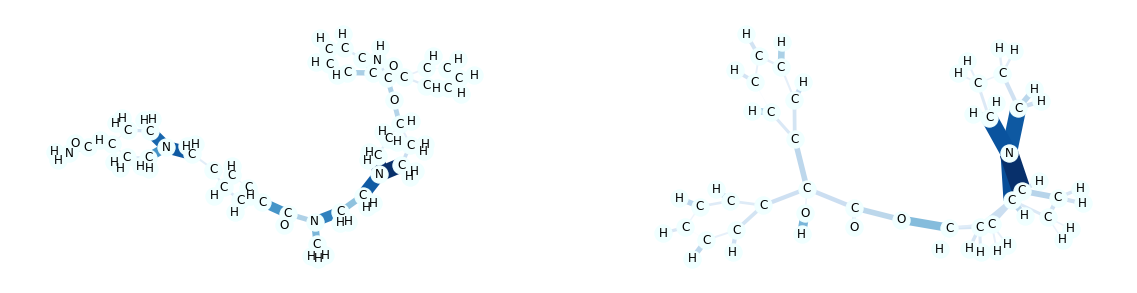

Drug 1: DB06212
Drug 2: DB11703


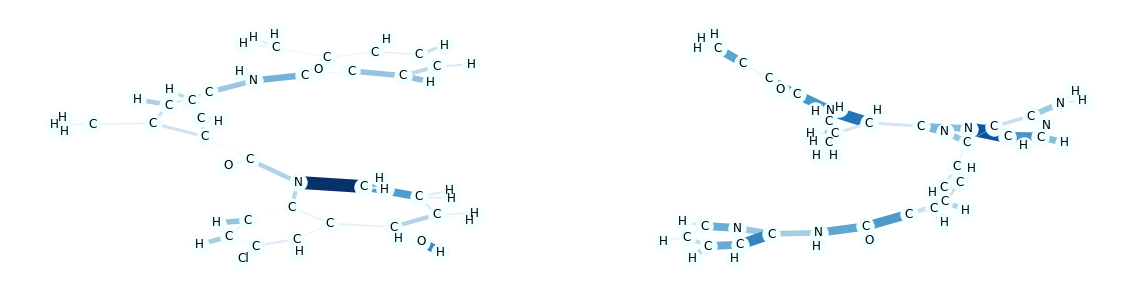

Drug 1: DB00454
Drug 2: DB01029


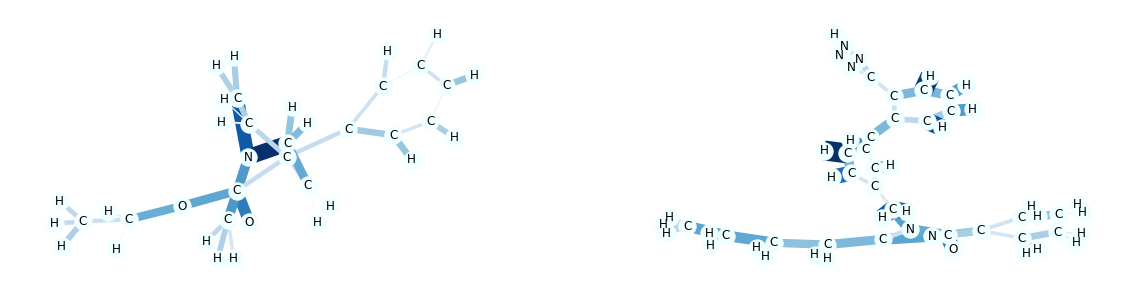

Drug 1: DB06774
Drug 2: DB11511


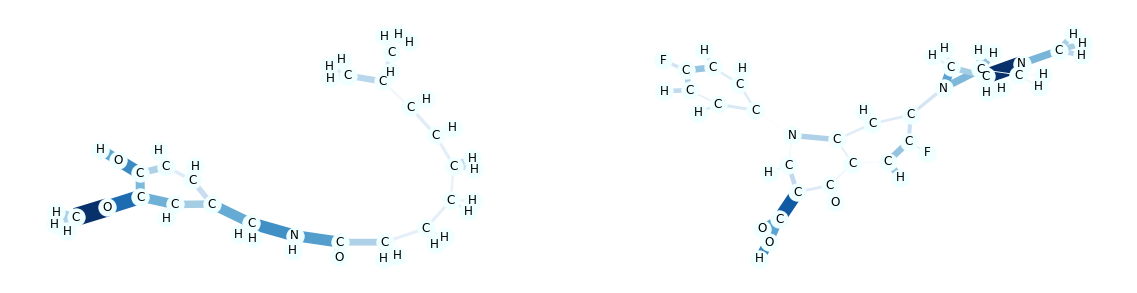

Drug 1: DB15102
Drug 2: DB09118


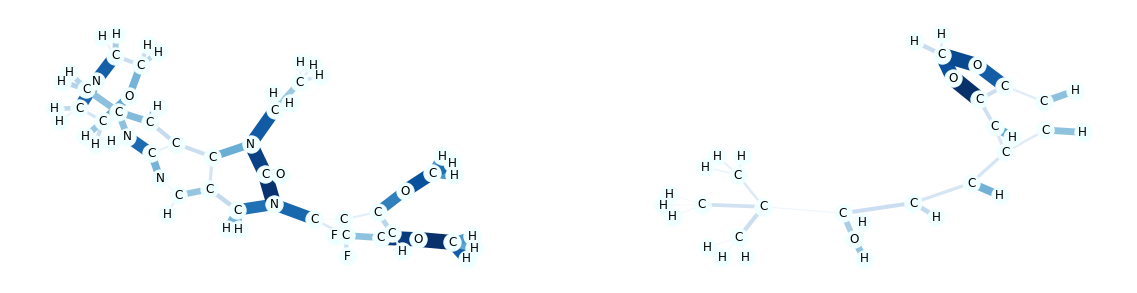

Drug 1: DB00831
Drug 2: DB00533


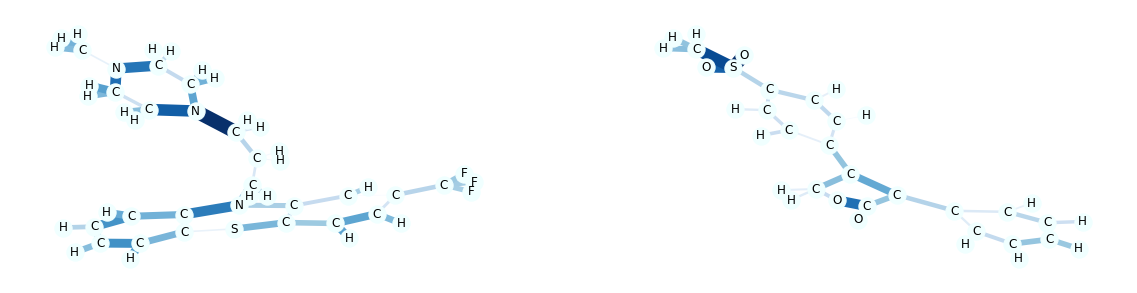

Drug 1: DB00489
Drug 2: DB00238


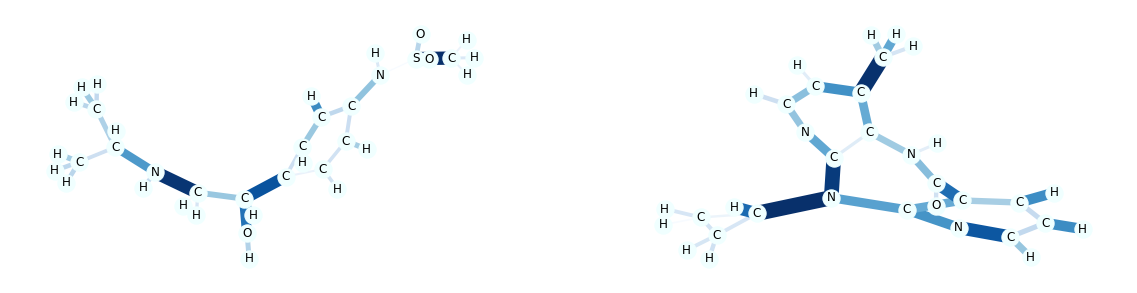

Drug 1: DB01580
Drug 2: DB00715


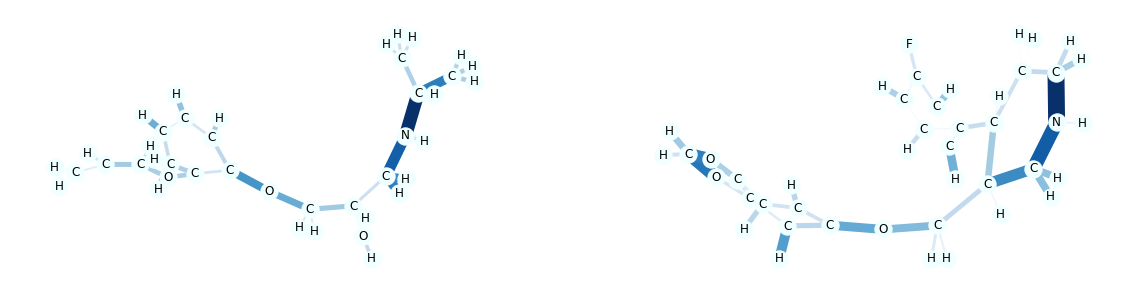

Drug 1: DB00590
Drug 2: DB01097


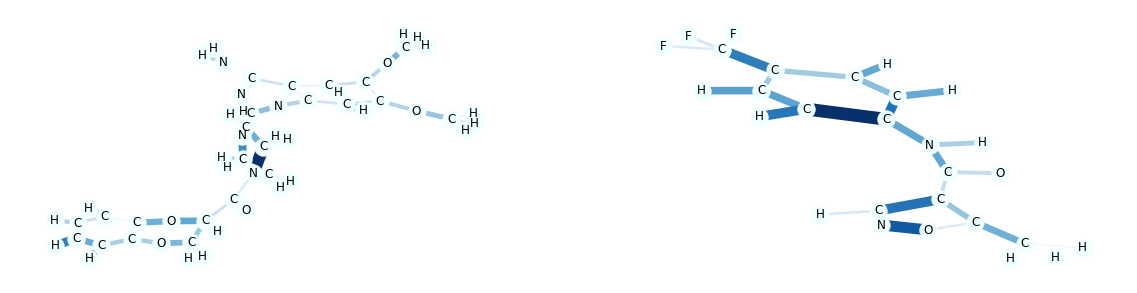

Drug 1: DB01142
Drug 2: DB06174


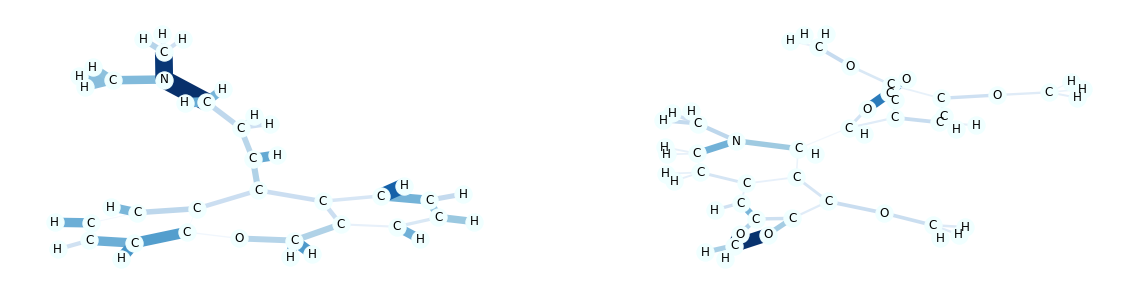

In [11]:
for i in range(10):
    pg = dataset[i]
    print(f'Drug 1: {dataset.id_to_drug[pg.ent1.item()]}')
    print(f'Drug 2: {dataset.id_to_drug[pg.ent2.item()]}')
    target = pg.target
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    plot_explain(model, pg, target, axs, method='ig')
    plt.show()

### Visualize edge attribution with Saliency

Drug 1: DB11855
Drug 2: DB00209


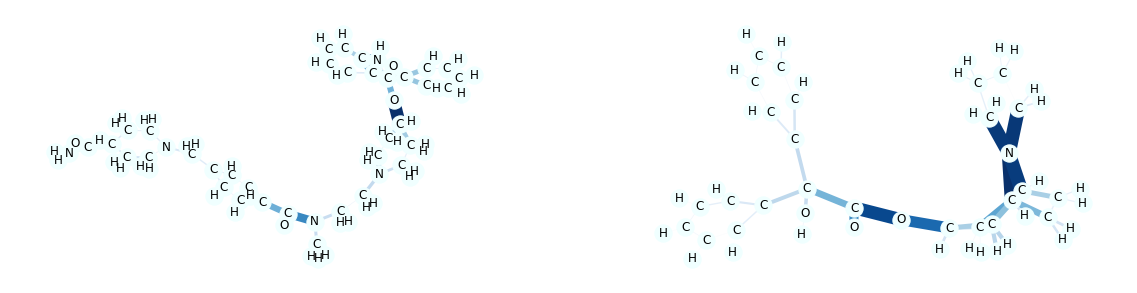

Drug 1: DB06212
Drug 2: DB11703


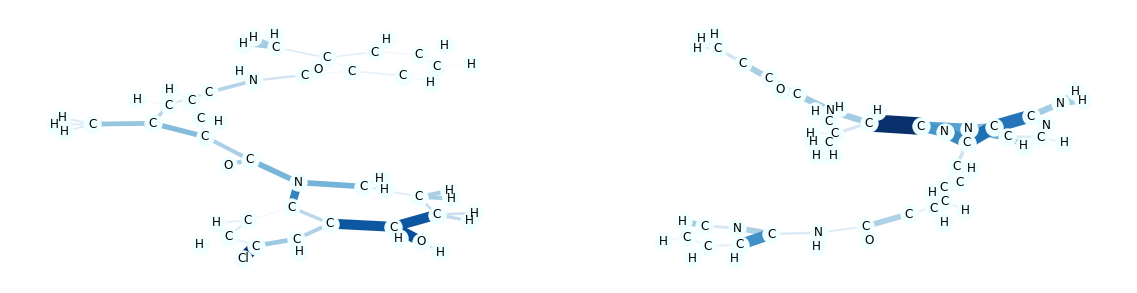

Drug 1: DB00454
Drug 2: DB01029


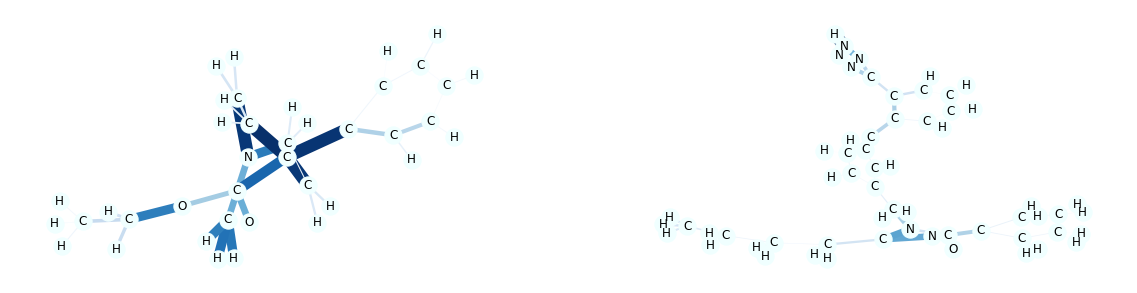

Drug 1: DB06774
Drug 2: DB11511


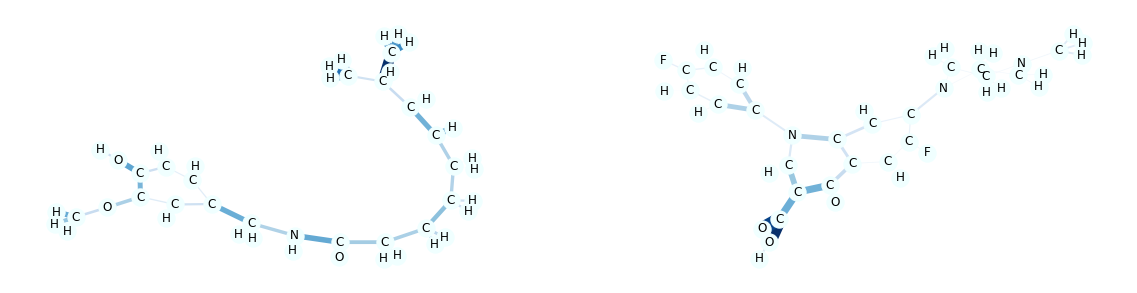

Drug 1: DB15102
Drug 2: DB09118


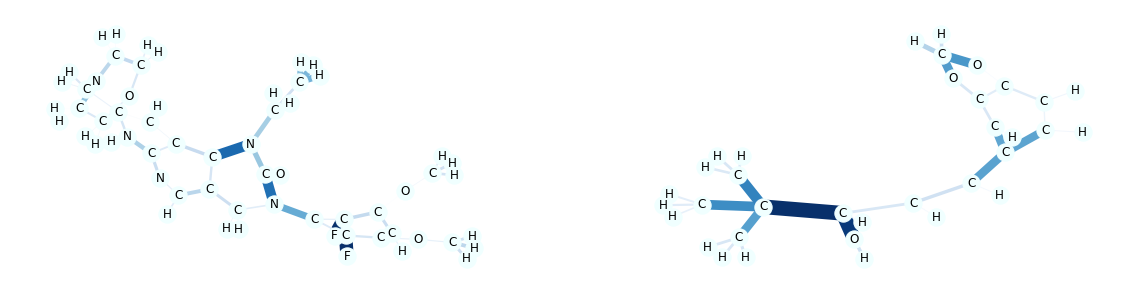

Drug 1: DB00831
Drug 2: DB00533


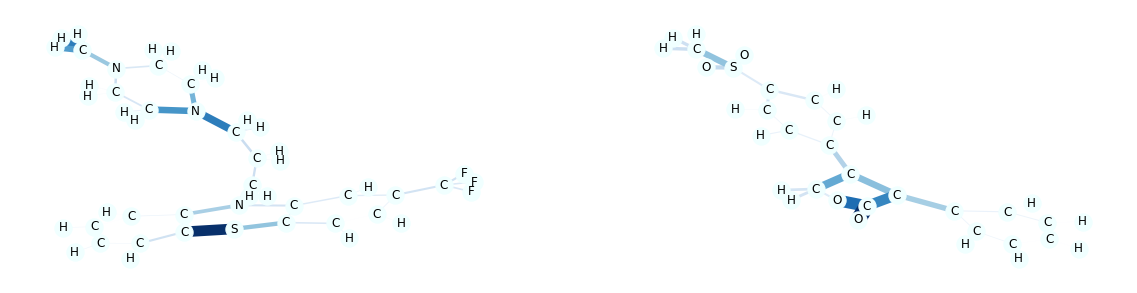

Drug 1: DB00489
Drug 2: DB00238


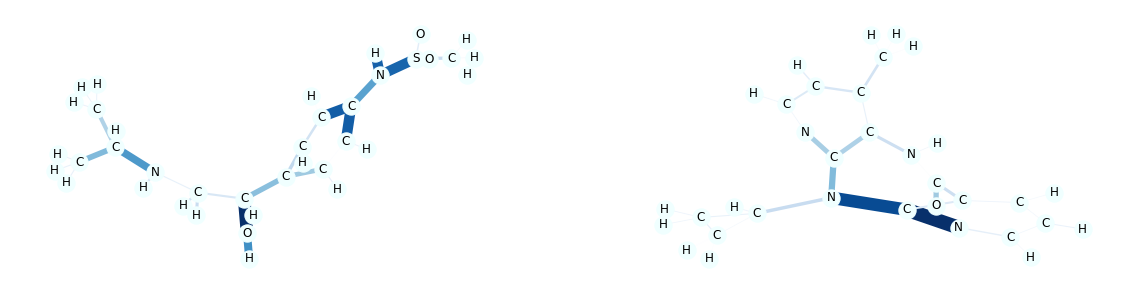

Drug 1: DB01580
Drug 2: DB00715


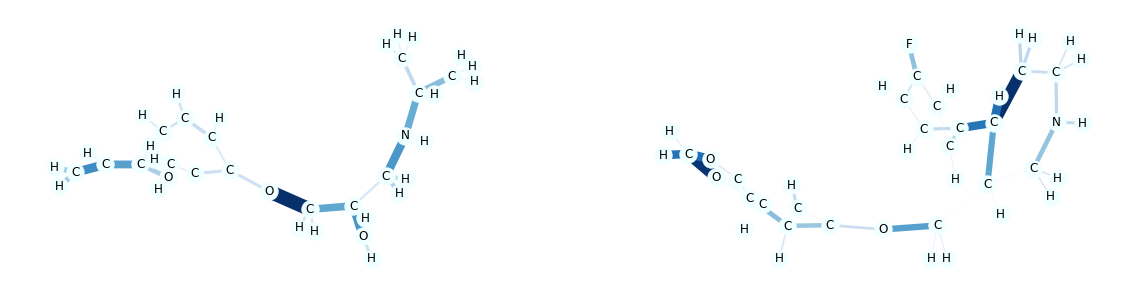

Drug 1: DB00590
Drug 2: DB01097


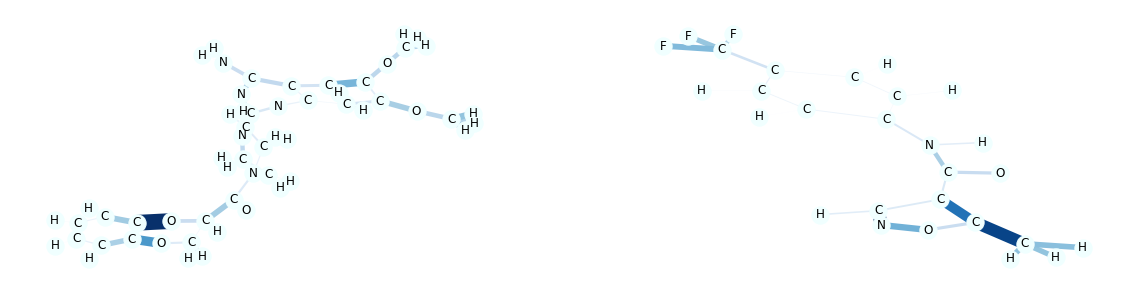

Drug 1: DB01142
Drug 2: DB06174


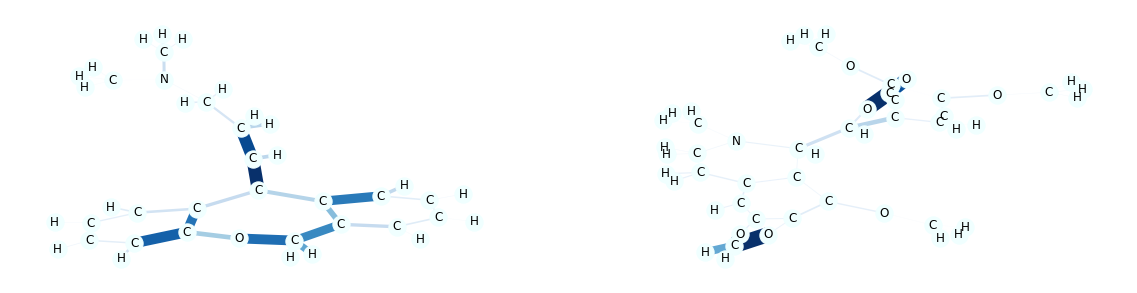

In [12]:
for i in range(10):
    pg = dataset[i]
    print(f'Drug 1: {dataset.id_to_drug[pg.ent1.item()]}')
    print(f'Drug 2: {dataset.id_to_drug[pg.ent2.item()]}')
    target = pg.target
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    plot_explain(model, pg, target, axs, method='saliency')
    plt.show()